Importing required Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
#import tensorflow as tf
#from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

# Data Preprocessing

For preprocessing:
- We have to convert the dataset into that acceptable by YOLO.
  - Heirarchy of folders should be the one accepted by YOLO
  - Labels format should be darknet YOLO.
  - Labels files should be .txt files
- Check and see if there are any missing labels or images. And remove them from dataset.

## Loading all files

In [ ]:
#run only once, no need to run if directory already exisits

#create directories as required by YOLO
os.makedirs('dataset/images', exist_ok=True)
os.makedirs('dataset/labels', exist_ok=True)
os.makedirs('dataset/images/train', exist_ok=True)
os.makedirs('dataset/labels/train', exist_ok=True)
os.makedirs('dataset/images/val', exist_ok=True)
os.makedirs('dataset/labels/val', exist_ok=True)

In [ ]:
#run only once, no need to run if directory already exisits

# name the paths
img_folder_1 = 'keggle_img_dataset_renamed'
img_folder_2 = 'self_gathered_data/new_images'
label_folder = 'self_gathered_data/all_labels'
output_img_train = 'dataset/images/train'
output_img_val = 'dataset/images/val'
output_label_train = 'dataset/labels/train'
output_label_val = 'dataset/labels/val'



# Gather all image and label paths
img_files = []
for folder in [img_folder_1, img_folder_2]:
    for file in os.listdir(folder):
        if file.endswith('.jpg') or file.endswith('.JPG'):
            img_files.append(os.path.join(folder, file))

label_files = [os.path.join(label_folder, file) for file in os.listdir(label_folder) if file.endswith('.txt')]

print(f"loaded {len(img_files)} image files")
print(f"loaded {len(label_files)} label files")

#data cleaning
#map img files to txt files (label files have the same name as image files)
img_to_label = {os.path.splitext(os.path.basename(img))[0]: img for img in img_files}
label_dict = {os.path.splitext(os.path.basename(label))[0]: label for label in label_files}

print(f"loaded {len(img_to_label)} valid img files")
print(f"loaded {len(label_dict)} valid labels files")


loaded 377 image files
loaded 377 label files
loaded 377 valid img files
loaded 377 valid labels files


## Spliting into Train-Test sets

In [ ]:
#run only once, no need to run if files already split

# Helper function to extract class info from filenames
## this preparation is because the numbers of samples for different classes are unbalanced (some has 90+ while some only has 60+)
## we need to do stratified splitting later to ensure balanced representation in our split
def extract_class_from_filename(filename):
    return filename.split('(')[0]  # Extracts everything before '('

# Filter to include only images with labels and group them by class
from collections import defaultdict
class_img_label_dict = defaultdict(list)
for img_name, img_path in img_to_label.items():
    if img_name in label_dict:
        class_name = extract_class_from_filename(img_name)
        class_img_label_dict[class_name].append((img_path, label_dict[img_name]))


#check the sample number for each class
for class_name, pairs in class_img_label_dict.items():
    print(f"Class '{class_name}' has {len(pairs)} samples")

Class 'GreenLeafHopper ' has 69 samples
Class 'PlantHopper ' has 66 samples
Class 'RiceBug ' has 95 samples
Class 'RiceLeafRoller ' has 77 samples
Class 'RiceStemBorer ' has 70 samples


In [ ]:


#perform train-test split
from sklearn.model_selection import train_test_split
train_imgs, val_imgs, train_labels, val_labels = [], [], [], []

for class_name, pairs in class_img_label_dict.items():
    imgs, labels = zip(*pairs)
    imgs_train, imgs_val, labels_train, labels_val = train_test_split(
        imgs,
        labels,
        test_size=0.2,
        random_state=42)
    train_imgs.extend(imgs_train)
    val_imgs.extend(imgs_val)
    train_labels.extend(labels_train)
    val_labels.extend(labels_val)

#for checking and debugging
from collections import Counter
# Count samples in train and validation splits by class
train_class_counts = Counter([extract_class_from_filename(os.path.basename(img)) for img in train_imgs])
val_class_counts = Counter([extract_class_from_filename(os.path.basename(img)) for img in val_imgs])

# Print the counts for each class in train and validation sets
for class_name in train_class_counts.keys() | val_class_counts.keys():
    train_count = train_class_counts.get(class_name, 0)
    val_count = val_class_counts.get(class_name, 0)
    print(f"{class_name}: \n{train_count} images for training, {val_count} images for validation")

RiceLeafRoller : 
61 samples for training, 16 samples for validation
PlantHopper : 
52 samples for training, 14 samples for validation
GreenLeafHopper : 
55 samples for training, 14 samples for validation
RiceStemBorer : 
56 samples for training, 14 samples for validation
RiceBug : 
76 samples for training, 19 samples for validation


In [ ]:
# copy images and labels to train/val folders
for img_path, label_path in zip(train_imgs, train_labels):
    shutil.copy(img_path, output_img_train)
    shutil.copy(label_path, output_label_train)

for img_path, label_path in zip(val_imgs, val_labels):
    shutil.copy(img_path, output_img_val)
    shutil.copy(label_path, output_label_val)

## Loading image with bounding box

In [58]:
#set the paths to labels and images directory
label_dir= "datasets/labels"
image_dir="datasets/images"

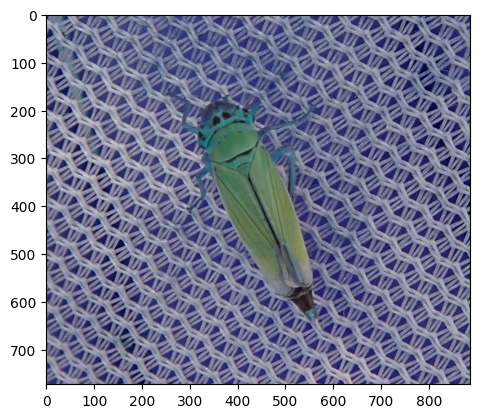

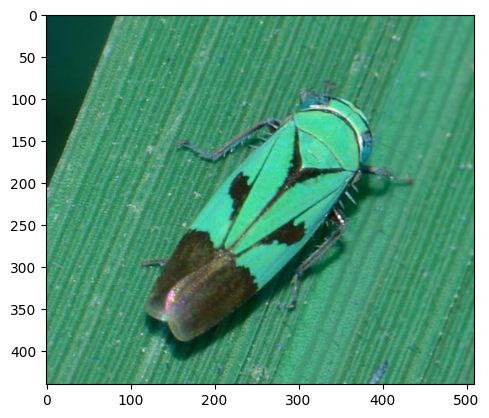

In [17]:
#no need to run, just for debug

#visualize first two sample images from train data
for idx, image in enumerate(os.listdir(os.path.join(image_dir, "train"))):
    img = cv2.imread(os.path.join(image_dir,"train", image), 1)
    plt.imshow(img)
    plt.show()

    if idx == 1:
        break

### Creating Text files for labels
Creating Dataframes from txt files

In [59]:
boundbox_data_train=[]

for filepath in glob.glob(label_dir+"/train/*.txt"):
    with open(filepath, 'r') as file:
        name = filepath.split('/')[-1].replace('.txt', '')  # Extract the image ID from filename

        for line in file:
            values = line.strip().split()  # Split by whitespace
            label = int(values[0])
            x_center, y_center, width, height = map(float, values[1:])

            # Append the data to the list
            boundbox_data_train.append({
                'name': name,
                'label': label,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height
            })

print (f"{len(boundbox_data_train)} files processed for train set")

boundbox_data_val=[]

for filepath in glob.glob(label_dir+"/val/*.txt"):
    with open(filepath, 'r') as file:
        name = filepath.split('/')[-1].replace('.txt', '')  # Extract the image ID from filename

        for line in file:
            values = line.strip().split()  # Split by whitespace
            label = int(values[0])
            x_center, y_center, width, height = map(float, values[1:])

            # Append the data to the list
            boundbox_data_val.append({
                'name': name,
                'label': label,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height
            })

print (f"{len(boundbox_data_val)} files processed for validation set")

# Create DataFrames
train_df=pd.DataFrame(boundbox_data_train)
val_df=pd.DataFrame(boundbox_data_val)

306 files processed for train set
81 files processed for validation set


Because some images contain more than one pest, we print the results in the dataframe to see how many pest samples we accuallty have for each class.

In [19]:
#no need to run, just for debug

# Count the samples for each class in the training set
train_class_counts = train_df['label'].value_counts()

# Count the samples for each class in the validation set
val_class_counts = val_df['label'].value_counts()

# Print the results
print("Class Distribution in Training Set:")
for label, count in train_class_counts.items():
    print(f"Class {label}: {count} samples")

print("\nClass Distribution in Validation Set:")
for label, count in val_class_counts.items():
    print(f"Class {label}: {count} samples")

Class Distribution in Training Set:
Class 2: 77 samples
Class 3: 63 samples
Class 0: 57 samples
Class 4: 56 samples
Class 1: 53 samples

Class Distribution in Validation Set:
Class 2: 18 samples
Class 4: 17 samples
Class 3: 17 samples
Class 0: 15 samples
Class 1: 14 samples


Visualizing one of the image in train set with the bounding box

Loading image at dataset/images\train\GreenLeafHopper (23).jpg
got corrdinates 200 97 378 221


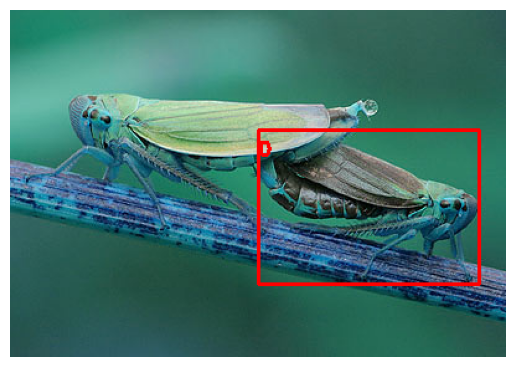

In [20]:
#no need to run, for debugging

index= 10 #picture to visualize

#read the img
image_path=os.path.join(image_dir, train_df["name"][index]+".jpg")
image = cv2.imread(image_path, 1)
print(f"Loading image at {image_path}")

if image is None:
    print("Error: Unable to load image with .jpg, trying .JPG")
    image = cv2.imread(os.path.join(image_dir, train_df["name"][index]+".JPG"), 1)

image_path = os.path.join(image_dir, "train", train_df["name"][index] + ".jpg")
if image is None:
    print(f"Error: Unable to load image at {image_path}")

# Get image dimensions
height, width, _ = image.shape

# Normalize bounding box coordinates (assumes YOLO format)
x_center = train_df['x_center'][index] * width
y_center = train_df['y_center'][index] * height
box_width = train_df['width'][index] * width
box_height = train_df['height'][index] * height

# Calculate the top-left and bottom-right corners of the bounding box
xmin = int(x_center - (box_width / 2))
ymin = int(y_center - (box_height / 2))
xmax = int(x_center + (box_width / 2))
ymax = int(y_center + (box_height / 2))

print ("got corrdinates", xmin, ymin, xmax, ymax)


# Draw rectangle
cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

# Put label (class_id) near the bbox
label = train_df["label"][index]
cv2.putText(image, str(label), (xmin, ymin+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

# Display image
plt.imshow(image)
plt.axis('off')
plt.show()

Checking to see if the above image has bounding boxes around other pests or not.

In [6]:
train_df["name"][index]
filtered_df = train_df[train_df['name'] == train_df["name"][index]]
print(filtered_df)

                          name  label  x_center  y_center     width    height
9   train\GreenLeafHopper (23)      0  0.393282  0.414083  0.609561  0.425065
10  train\GreenLeafHopper (23)      0  0.723385  0.570413  0.444961  0.443152


Checking to see the datatypes of all the columns and if there is any null value that needs to be eliminated from the data.

In [60]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      81 non-null     object 
 1   label     81 non-null     int64  
 2   x_center  81 non-null     float64
 3   y_center  81 non-null     float64
 4   width     81 non-null     float64
 5   height    81 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 3.9+ KB


What different types of labels are assigned to each sample and checking if they match the provided label/class information, i.e. there are no extra labels due to mistakes in spellings etc.

In [8]:
print(train_df['label'].unique())
print(val_df['label'].unique())

[0 1 2 3 4]
[0 1 2 3 4]


We need to map labels to class_ids required for YOLO

In [65]:
label_map = { 0: 0,
            1: 1,
            2: 2,
            3:3,
            4:4}

train_df['class'] = train_df['label'].map(label_map)
val_df['class'] = val_df['label'].map(label_map)

In [67]:
train_df.head()

,name,label,x_center,y_center,width,height,class
0,train\GreenLeafHopper (10),0,0.490992,0.540052,0.355797,0.614987,0
1,train\GreenLeafHopper (11),0,0.514491,0.556848,0.581851,0.702842,0
2,train\GreenLeafHopper (12),0,0.500000,0.471576,0.176646,0.348837,0
3,train\GreenLeafHopper (15),0,0.545030,0.465116,0.263161,0.147287,0
4,train\GreenLeafHopper (16),0,0.276786,0.431818,0.530844,0.691558,0


convertig the bounding box format to the one required by YOLO:

In [12]:
#we don't need this step from the lab since our txt files are already in YOLO format

# # Training data
# train_df['x_center'] = (train_df['xmin']+train_df['xmax'])/(2*train_df["width"])
# train_df['y_center'] = (train_df['ymin']+train_df['ymax'])/(2*train_df["height"])
# train_df['box_width'] = (train_df['xmax']-train_df['xmin'])/ train_df["width"]
# train_df['box_height'] = (train_df['ymax']-train_df['ymin'])/train_df["height"]

# #Validation data
# val_df['x_center'] = (val_df['xmin']+val_df['xmax'])/(2*val_df["width"])
# val_df['y_center'] = (val_df['ymin']+val_df['ymax'])/(2*val_df["height"])
# val_df['box_width'] = (val_df['xmax']-val_df['xmin'])/ val_df["width"]
# val_df['box_height'] = (val_df['ymax']-val_df['ymin'])/val_df["height"]

In [68]:
train_df.head()

,name,label,x_center,y_center,width,height,class
0,train\GreenLeafHopper (10),0,0.490992,0.540052,0.355797,0.614987,0
1,train\GreenLeafHopper (11),0,0.514491,0.556848,0.581851,0.702842,0
2,train\GreenLeafHopper (12),0,0.500000,0.471576,0.176646,0.348837,0
3,train\GreenLeafHopper (15),0,0.545030,0.465116,0.263161,0.147287,0
4,train\GreenLeafHopper (16),0,0.276786,0.431818,0.530844,0.691558,0


Deleting all the sample with Nan values in training and validation data

In [69]:
#training
print("before deleting (train data): " , train_df.shape)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("after deleting(train_data): " ,train_df.shape)

#validation
print("before deleting (val data): " , val_df.shape)
val_df.replace([np.inf, -np.inf], np.nan, inplace=True)
val_df.dropna(inplace=True)
print("after deleting(val data): " , val_df.shape)

before deleting (train data):  (306, 7)
after deleting(train_data):  (306, 7)
before deleting (val data):  (81, 7)
after deleting(val data):  (81, 7)


converting the dataframe to type str (string) to be stored in text files.

In [70]:
train_df = train_df.astype(str)
val_df = val_df.astype(str)

If there are more than one bounding boxes in single image, they should be written in one text file. As, you can see in the below example that one image has so many bounding boxes.

In [135]:
filtered_df = train_df[train_df['name'] == train_df["name"][10]]
(filtered_df.head(15))

,name,label,x_center,y_center,width,height,class
9,train\GreenLeafHopper (23),0,0.393282,0.414083,0.609561,0.425065,0
10,train\GreenLeafHopper (23),0,0.723385,0.570413,0.444961,0.443152,0


In [75]:
#file_name = [x.split('.')[0] for x in df1["name"]]

#TRAINING DATA
#finding all the unique names:
unique_names= train_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = train_df[train_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['width']+" "+row['height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/{name}.txt', 'w') as file:
            file.write(text)
#############################################################################################
#VALIDATION DATA
#finding all the unique names:
unique_names= val_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = val_df[val_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['width']+" "+row['height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/{name}.txt', 'w') as file:
            file.write(text)

# Checking Missing Files

Checking the folders if every image file has a corresponding label file
(We will copy the code, we already used in previous turorial after updating)


In [95]:
#The lists of all the images and labels for train and validation set:
#JPG & jpg debug done by Chat-GPT
train_images = glob.glob(os.path.join(image_dir, "train", '*.[jJ][pP][gG]'))
train_labels=glob.glob(os.path.join(label_dir, "train",'*.txt'))
val_images = glob.glob(os.path.join(image_dir, "val", '*.[jJ][pP][gG]'))
val_labels=glob.glob(os.path.join(label_dir, "val",'*.txt'))
print(train_images)

# Get the list of filenames without extensions
image_files_train = {file.split("/")[-1].split(".")[0] for file in train_images}
label_files_train = {file.split("/")[-1].split(".")[0] for file in train_labels}

image_files_val = {file.split("/")[-1].split(".")[0] for file in val_images}
label_files_val = {file.split("/")[-1].split(".")[0] for file in val_labels}
print(image_files_val)




['dataset/images\\train\\GreenLeafHopper (10).jpg', 'dataset/images\\train\\GreenLeafHopper (11).jpg', 'dataset/images\\train\\GreenLeafHopper (12).jpg', 'dataset/images\\train\\GreenLeafHopper (15).jpg', 'dataset/images\\train\\GreenLeafHopper (16).jpg', 'dataset/images\\train\\GreenLeafHopper (17).jpg', 'dataset/images\\train\\GreenLeafHopper (2).jpg', 'dataset/images\\train\\GreenLeafHopper (21).jpg', 'dataset/images\\train\\GreenLeafHopper (22).jpg', 'dataset/images\\train\\GreenLeafHopper (23).jpg', 'dataset/images\\train\\GreenLeafHopper (24).jpg', 'dataset/images\\train\\GreenLeafHopper (25).jpg', 'dataset/images\\train\\GreenLeafHopper (27).jpg', 'dataset/images\\train\\GreenLeafHopper (28).jpg', 'dataset/images\\train\\GreenLeafHopper (29).jpg', 'dataset/images\\train\\GreenLeafHopper (30).jpg', 'dataset/images\\train\\GreenLeafHopper (31).jpg', 'dataset/images\\train\\GreenLeafHopper (32).JPG', 'dataset/images\\train\\GreenLeafHopper (33).jpg', 'dataset/images\\train\\GreenLe

In [108]:
#debug code

file_path = "IAT360_CV_Project_Pest-main-3//dataset/images//RiceStemBorer (30).jpg"

##Replace double slashes with a single slash
cleaned_path = file_path.replace("//", "/")
print(cleaned_path)

# Normalize file paths by replacing double backslashes and ensuring forward slashes
def normalize_path(path):
    return path.replace("\\", "/").replace("//", "/")

for uncleaned_path in image_files_val:
    uncleand_path=uncleaned_path.replace("images", "/")

print(image_files_val)



train_images = [normalize_path(img) for img in train_images]
train_labels = [normalize_path(lbl) for lbl in train_labels]
val_images = [normalize_path(img) for img in val_images]
val_labels = [normalize_path(lbl) for lbl in val_labels]


IAT360_CV_Project_Pest-main-3/dataset/images/RiceStemBorer (30).jpg
{'images\\val\\GreenLeafHopper (14)', 'images\\val\\RiceLeafRoller (1)', 'images\\val\\RiceLeafRoller (19)', 'images\\val\\RiceLeafRoller (50)', 'images\\val\\PlantHopper (66)', 'images\\val\\PlantHopper (7)', 'images\\val\\RiceLeafRoller (13)', 'images\\val\\RiceBug (13)', 'images\\val\\GreenLeafHopper (20)', 'images\\val\\RiceStemBorer (19)', 'images\\val\\GreenLeafHopper (48)', 'images\\val\\PlantHopper (6)', 'images\\val\\RiceBug (3)', 'images\\val\\RiceLeafRoller (20)', 'images\\val\\RiceBug (76)', 'images\\val\\RiceStemBorer (54)', 'images\\val\\RiceLeafRoller (52)', 'images\\val\\RiceBug (52)', 'images\\val\\GreenLeafHopper (60)', 'images\\val\\GreenLeafHopper (19)', 'images\\val\\RiceBug (1)', 'images\\val\\GreenLeafHopper (3)', 'images\\val\\RiceLeafRoller (41)', 'images\\val\\RiceBug (26)', 'images\\val\\PlantHopper (64)', 'images\\val\\PlantHopper (3)', 'images\\val\\RiceBug (33)', 'images\\val\\RiceBug (75)

In [97]:
print(len(image_files_val), "  =  ", len(label_files_val))

77   =   77


In [98]:
# Find extra files in each folder

#TRAINING DATA
extra_images_train = image_files_train - label_files_train
extra_labels_train = label_files_train - image_files_train

# Output the results
print(f"Training Extra images (without corresponding labels): {extra_images_train}")
print(f"Training Extra labels (without corresponding images): {extra_labels_train}")


#VALIDATION DATA
extra_images_val = image_files_val - label_files_val
extra_labels_val = label_files_val - image_files_val

# Output the results
print(f"Validation Extra images (without corresponding labels): {extra_images_val}")
print(f"Validation Extra labels (without corresponding images): {extra_labels_val}")

Training Extra images (without corresponding labels): {'images\\train\\GreenLeafHopper (37)', 'images\\train\\RiceStemBorer (40)', 'images\\train\\RiceLeafRoller (33)', 'images\\train\\RiceBug (60)', 'images\\train\\RiceStemBorer (27)', 'images\\train\\RiceBug (49)', 'images\\train\\RiceBug (62)', 'images\\train\\RiceBug (2)', 'images\\train\\RiceStemBorer (60)', 'images\\train\\PlantHopper (37)', 'images\\train\\RiceLeafRoller (15)', 'images\\train\\RiceStemBorer (57)', 'images\\train\\RiceLeafRoller (21)', 'images\\train\\GreenLeafHopper (4)', 'images\\train\\RiceBug (40)', 'images\\train\\RiceBug (17)', 'images\\train\\GreenLeafHopper (51)', 'images\\train\\GreenLeafHopper (39)', 'images\\train\\GreenLeafHopper (65)', 'images\\train\\GreenLeafHopper (27)', 'images\\train\\RiceBug (23)', 'images\\train\\RiceLeafRoller (23)', 'images\\train\\RiceLeafRoller (44)', 'images\\train\\RiceLeafRoller (72)', 'images\\train\\RiceBug (22)', 'images\\train\\RiceLeafRoller (48)', 'images\\train\\

Make sure that the above info is correct by chceking the data manually.

Now removing from the dataset:

In [ ]:
for file in extra_images_train:
     os.remove(os.path.join(image_dir, "train", file + '.jpg')) # or '.png' depending on your image format

for file in extra_images_val:
     os.remove(os.path.join(image_dir, "val", file + '.jpg'))

Now run the above cells again to find if all the missing data is deleted.

#Custom object detection using YOLO

First install and import

In [109]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.23  Python-3.12.7 torch-2.5.0+cpu CPU (Intel Core(TM) i5-9300H 2.40GHz)
Setup complete  (8 CPUs, 11.8 GB RAM, 338.1/475.8 GB disk)


In [110]:
from ultralytics import YOLO

# Training YOLO

We are going to select small pretrained (on COCO dataset) model of YOLOv8

In [111]:
model = YOLO('yolov8s.pt') # pretrained model

100%|██████████| 21.5M/21.5M [00:01<00:00, 14.7MB/s]


The detailed architecture of the model can be seen from:

In [112]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [133]:
%%writefile config.yaml
#write the full path to get to the correct directory, debug help sent by Chat-GPT
path: C:/Users/sylvi/OneDrive/Documents/GitHub/IAT360_CV_Project_Pest/datasets
train: images/train
val: images/val

# Classes
nc: 5 # replace based on your dataset's number of classes

# Class names
# replace all class names with your own classes' names
names:
  0: Green Leaf Hopper
  1: Plant Hopper
  2: Rice Bug
  3: Rice Leaf Roller
  4: Rice Stem Borer

Overwriting config.yaml


Please look at Yolo train Docs for hyperparameters for model tuning and configuration, e.g. lr0, imgsz, model etc.

In [134]:
model.train(data="config.yaml",epochs=5,patience=5,batch=8, lr0=0.0005,imgsz=640)

New https://pypi.org/project/ultralytics/8.3.24 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.23  Python-3.12.7 torch-2.5.0+cpu CPU (Intel Core(TM) i5-9300H 2.40GHz)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=config.yaml, epochs=5, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_

train: Scanning C:\Users\sylvi\OneDrive\Documents\GitHub\IAT360_CV_Project_Pest\datasets\labels\train... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:06<00:00, 43.57it/s]

train: New cache created: C:\Users\sylvi\OneDrive\Documents\GitHub\IAT360_CV_Project_Pest\datasets\labels\train.cache



val: Scanning C:\Users\sylvi\OneDrive\Documents\GitHub\IAT360_CV_Project_Pest\datasets\labels\val... 77 images, 0 backgrounds, 0 corrupt: 100%|██████████| 77/77 [00:00<00:00, 1082.28it/s]

val: New cache created: C:\Users\sylvi\OneDrive\Documents\GitHub\IAT360_CV_Project_Pest\datasets\labels\val.cache


Plotting labels to runs\detect\train10\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train10
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.375      3.039      1.711         11        640: 100%|██████████| 38/38 [04:55<00:00,  7.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:35<00:00,  7.17s/it]

                   all         77         81      0.361      0.501      0.398      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.283      2.188       1.56          9        640: 100%|██████████| 38/38 [04:58<00:00,  7.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.53s/it]

                   all         77         81      0.485      0.407      0.358      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.287      1.869      1.569         10        640: 100%|██████████| 38/38 [05:23<00:00,  8.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.56s/it]

                   all         77         81      0.608      0.542      0.543      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.263      1.592      1.539         12        640: 100%|██████████| 38/38 [05:30<00:00,  8.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.99s/it]

                   all         77         81      0.528      0.636      0.656      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.227      1.457      1.455         11        640: 100%|██████████| 38/38 [05:33<00:00,  8.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.95s/it]

                   all         77         81      0.689      0.563      0.701       0.44



5 epochs completed in 0.480 hours.
Optimizer stripped from runs\detect\train10\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train10\weights\best.pt, 22.5MB

Validating runs\detect\train10\weights\best.pt...
Ultralytics 8.3.23  Python-3.12.7 torch-2.5.0+cpu CPU (Intel Core(TM) i5-9300H 2.40GHz)
Model summary (fused): 168 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.87s/it]


                   all         77         81      0.689      0.563      0.701       0.44
     Green Leaf Hopper         14         15      0.848      0.376       0.74      0.532
          Plant Hopper         14         14        0.2     0.0714      0.338      0.182
              Rice Bug         18         18      0.568      0.778       0.69      0.308
      Rice Leaf Roller         17         17      0.989      0.824      0.893      0.601
       Rice Stem Borer         14         17      0.841      0.765      0.842      0.578
Speed: 3.6ms preprocess, 289.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\train10


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000270DDE3F020>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
    

# Evaluation Metrics

[This](https://www.google.com/url?q=https%3A%2F%2Fdocs.ultralytics.com%2Fguides%2Fyolo-performance-metrics%2F) is a very good detailed explanation of different perfromance metrics in YOLO.

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

*   mAP: Suitable for a broad assessment of model performance.
*   IoU: Essential when precise object location is crucial.
*   Precision: Important when minimizing false detections is a priority.
*   Recall: Vital when it's important to detect every instance of an object.
*   F1 Score: Useful when a balance between precision and recall is needed.


In [136]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics 8.3.23  Python-3.12.7 torch-2.5.0+cpu CPU (Intel Core(TM) i5-9300H 2.40GHz)
Model summary (fused): 168 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning C:\Users\sylvi\OneDrive\Documents\GitHub\IAT360_CV_Project_Pest\datasets\labels\val.cache... 77 images, 0 backgrounds, 0 corrupt: 100%|██████████| 77/77 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


                   all         77         81      0.696      0.619      0.722      0.442
     Green Leaf Hopper         14         15      0.877      0.477      0.741      0.533
          Plant Hopper         14         14      0.286      0.143      0.403      0.203
              Rice Bug         18         18      0.581      0.889      0.714      0.298
      Rice Leaf Roller         17         17      0.918      0.824      0.893      0.589
       Rice Stem Borer         14         17      0.819      0.765      0.857      0.585
Speed: 1.8ms preprocess, 243.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\train102


np.float64(0.6193868472749726)

Showing confusion matrix, that is already stored in detect/train folder

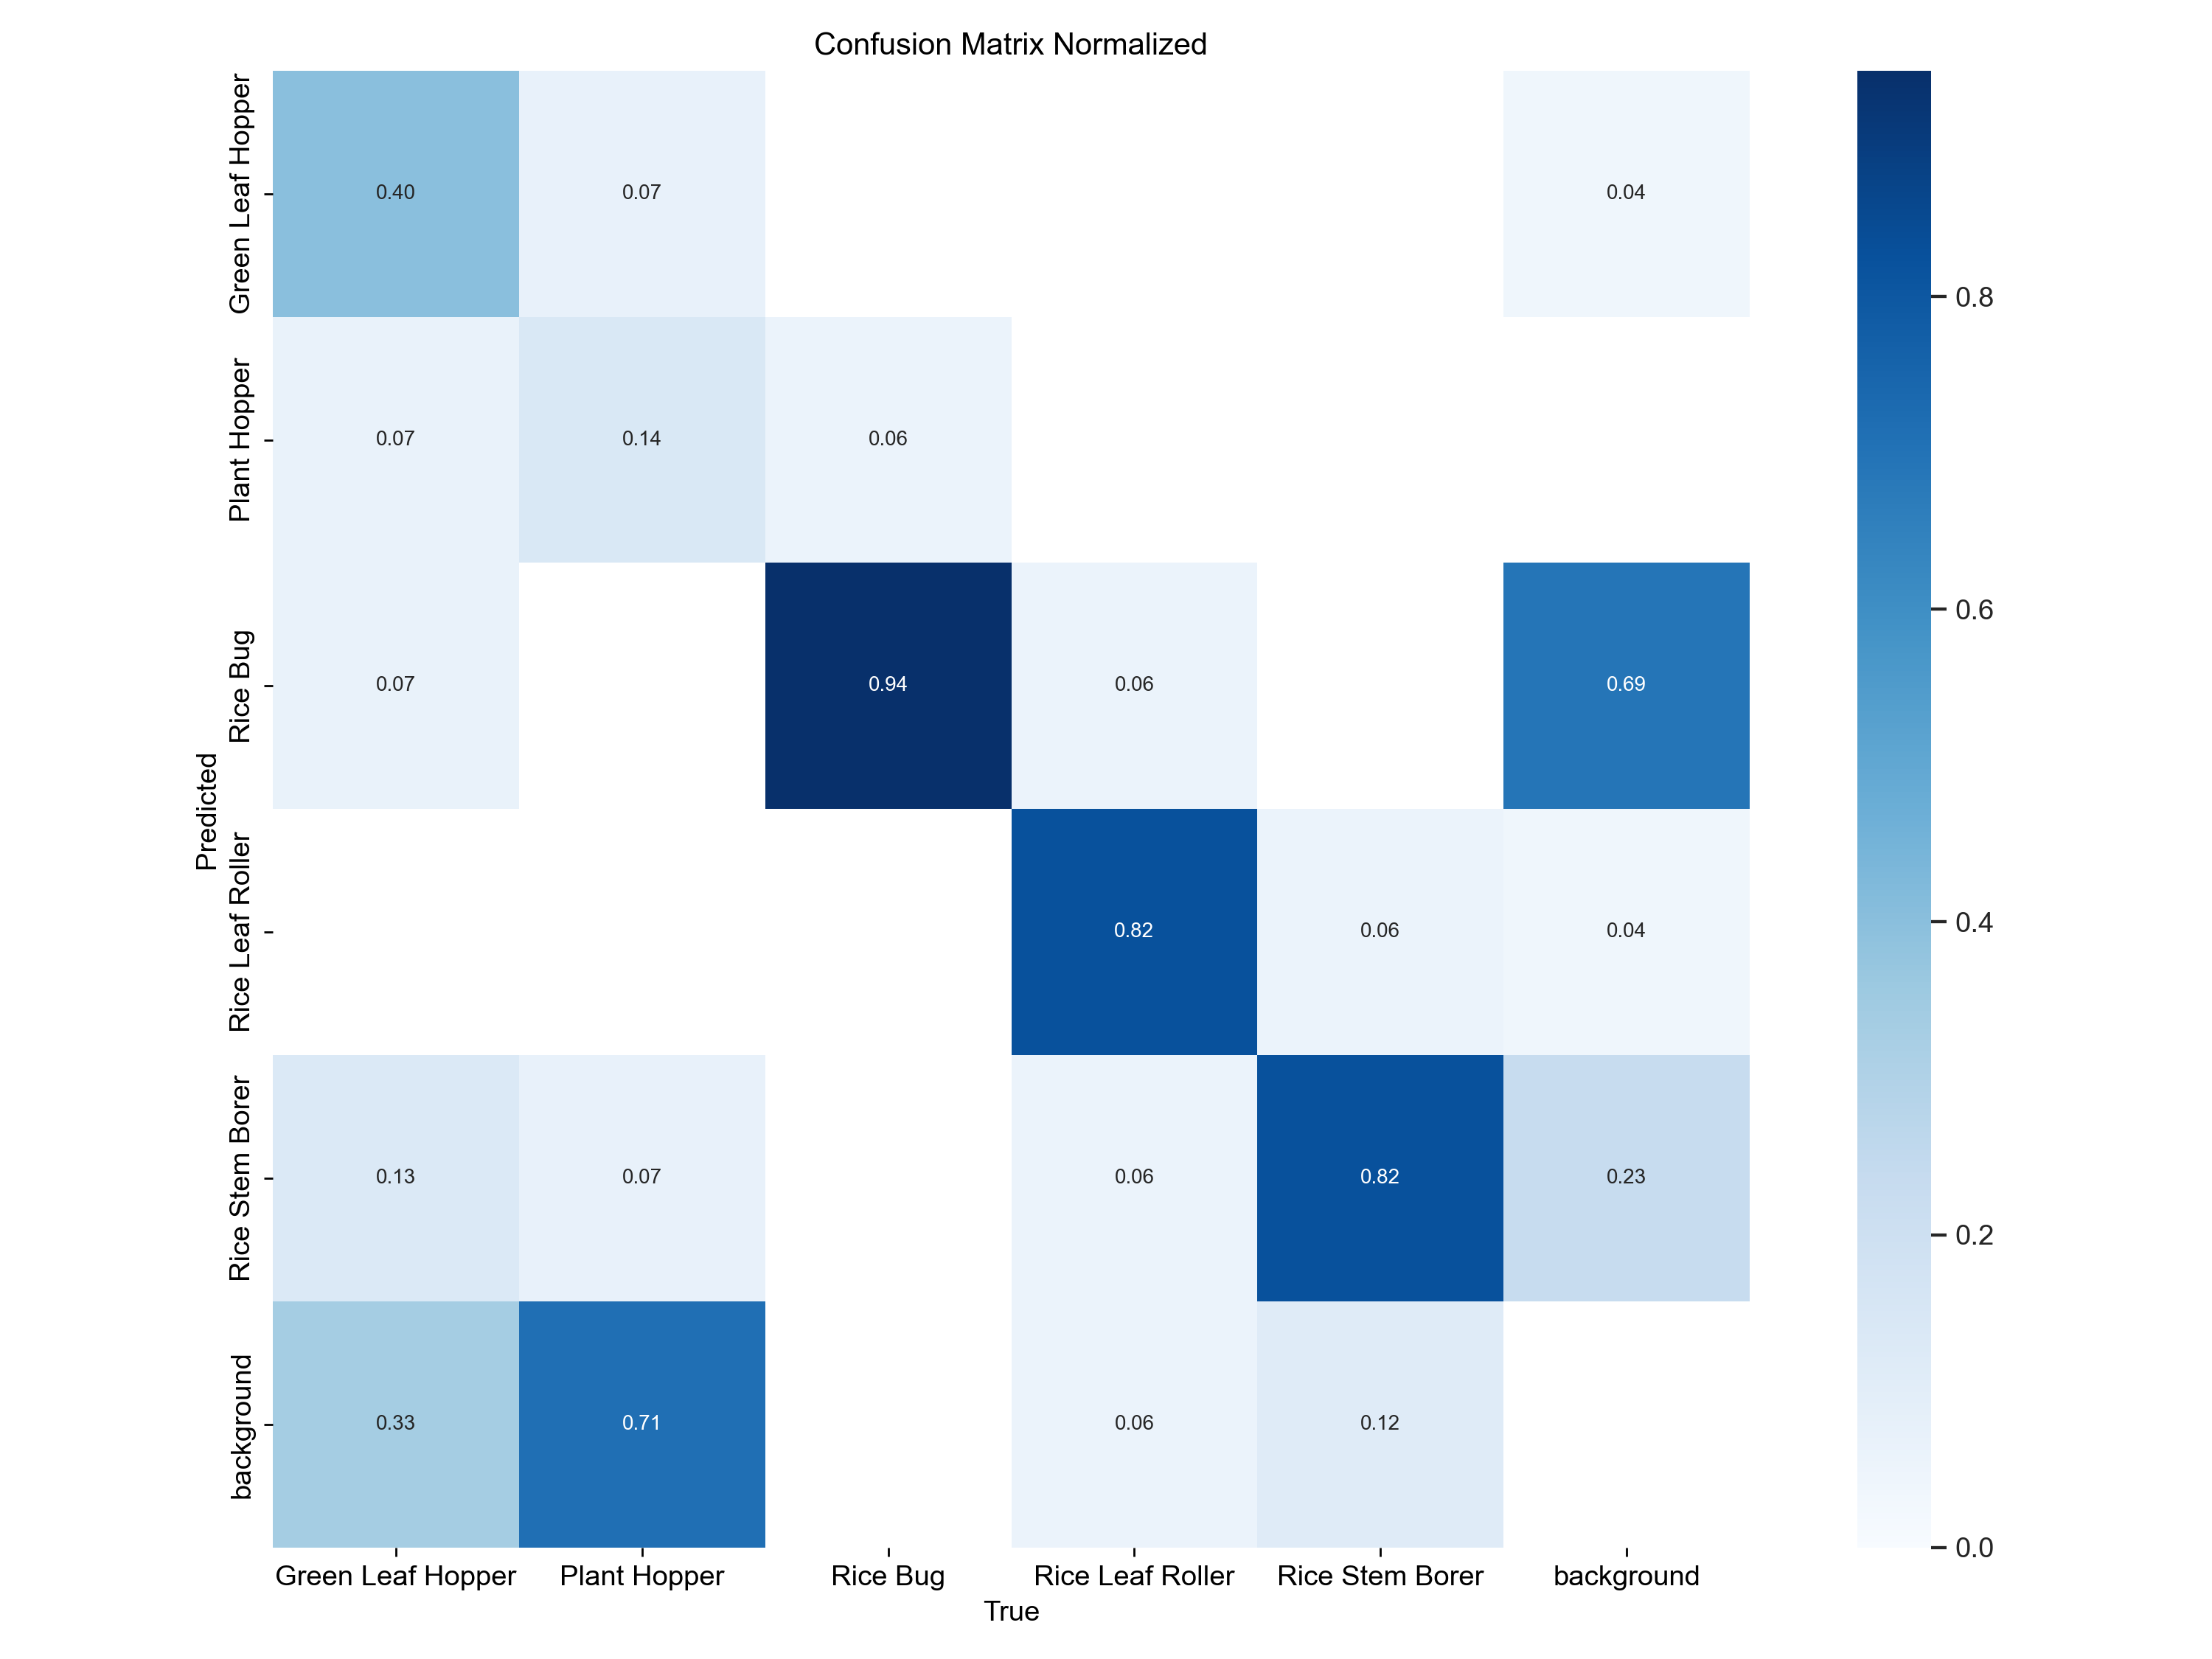

In [138]:
%matplotlib inline
from PIL import Image

Image.open('runs/detect/train102/confusion_matrix_normalized.png')

Double-click (or enter) to edit

#Prediction

In [ ]:
model = YOLO(' )  # load a custom model

# Predict with the model with any image from internet?
results = model('https://www.freshpoint.com/wp-content/uploads/2019/08/freshpoint-produce-101-apples-bananas.jpg', save=True)

In [ ]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/predict/freshpoint-produce-101-apples-bananas.jpg')